#**Data Privacy: Computer Homework 01**


Sharif Univesity of  Technology - EE dept.

by Prof. Yassaee, Fall 2023

Khashayar Ghaffari | 98100215

https://github.com/KhashayarGhaffari01/Differential-Privacy



---



# *Question 1*: In this question we want to demonstrate membership inference attacks on means by test statistics



First, tuneable simulation parameters:

In [1]:
import numpy as np
from scipy import stats
import math

In [2]:
np.random.seed(123)

n_sim=1000
n_samples=10
k_att=100

Then, define utility functions for simulating data and calculating the test statistics:


In [3]:
def synthesize(population_prob, n=1):
  return np.random.binomial(n=1, p=population_prob, size=(n, len(population_prob)))


#test statistics:
def test_homer(alice, sample_mean, population_mean):
  test_statistic= sum (abs(alice - population_mean)-abs(alice - sample_mean))
  return test_statistic


def test_dwork(alice, sample_mean, population_mean):
  test_statistic = sum( (alice-population_mean) *  (sample_mean-population_mean) ) 
  return test_statistic



def null_distribution (funny, population_prob, population_mean, null_sims=1000, alpha=0.05):
  hold = []

  for i in range(null_sims):
      sample_mean = synthesize(population_prob, n=n_samples).mean(axis=0)
      null_alice = synthesize(population_prob)[0]

      hold.append(funny(null_alice, sample_mean, population_mean))

  null_dist_vals = np.sort(hold)[::-1]
  return {
      "nulldist": null_dist_vals,
      "critical_val": null_dist_vals[round(alpha * null_sims)]
  }

Create Simple graph function for showing the distribution, partitioned by critical value, then Simulate and graph a null distribution:

In [4]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gaussian_kde.html


Now create a complete simulation of attack. We are going to iterate across datasets, calculate the discrimination of the test statistic among observations in the private data and the null population.

In [5]:
history = np.zeros(shape(n_sim,4))

nulldist_homer()
nulldist_dwork()

NameError: name 'shape' is not defined



---



# *Question 2:* Now Let's bulid  Laplace Mechanism for Differential Privacy

First, construct the basic building blocks for a Laplace mechanism, a random sampler from the distribution, a clamp/clip/censor function, the function for the true mean, and then the DP release algorithm itself.

In [6]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt

In [7]:
#Laplace:
def Laplace(shift, scale, size):
    return np.random.laplace(loc=shift, scale=scale, size=size)


#Clamp:
def Clamp(x, bounds):
    lower = bounds[0]
    upper = bounds[1]
    return np.clip(x, lower, upper)


#bounded mean:
def bounded_mean(x, bounds):
    return np.mean(Clamp(x, bounds))


#dp mean:
def release_dp_mean(x, epsilon, bounds):
    n = len(x)
    sensitivity = (bounds[1]-bounds[0])/n 
    return bounded_mean(x, bounds) + Laplace(0, sensitivity/epsilon, size=None)


Read in the data.  We're going to use the PUMS dataset, and focus on the education variable, a 16 point scale:

In [8]:
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

n = len(data)
bounds = (1, 16)
educ = data['educ'].values.astype(float)
print("real mean: " , np.mean(educ))
print("DP mean: " , release_dp_mean(educ, 1, bounds))

real mean:  10.608553908251183
DP mean:  10.608844480107265


Now that we have a mechanism available, let's try a new one, the histogram.  Histograms give counts of the number of observations within defined partitions of the variable domain.  Consider carefully the sensitivity for the histogram, which depends on which definition of neighbouring we are using. After that,  call your privacy-preserving histogram.

In [9]:
def release_histogram(x, epsilon, categories):
  sensitivity = 1

  counts = dict(zip(*np.unique(x, return_counts=True)))

  sensitivity_histogram = []

  for i in categories:
    sensitivity_histogram.append(counts.get(i, 0))

  sensitivity_histogram = np.array(sensitivity_histogram)

  return sensitivity_histogram + Laplace(0, sensitivity/epsilon, size=sensitivity_histogram.shape)


print(release_histogram(educ, 1, range(1,17)))    

[ 271.44187078  140.20968732  357.1082865   469.57792375  496.83301573
  760.25783489  894.46149509 1059.96111758 5146.75695349 1395.62364121
 3964.61267272 1154.86891645 6281.87435361 2268.77195509  795.64624606
  307.99209676]


Now we want to to simulate repeated draws from the Laplace mechanism to examine the utility it offers over the range of epsilon values and dataset sizes, for our education variable. We'll need a way to construct new datasets, given we only have one available.  The (nonparametric) bootstrap function lets us construct datasets even larger than our original source data if needed, by treating the sample data as if it is a population from which we can resample.

In [10]:
def bootstrap(x, n):
  return np.random.choice(x, n)

n_sim = np.random.randint(150, 1150, 20)
eps_sim = np.random.rand(5)

n_sim = sorted(n_sim)
eps_sim = sorted(eps_sim) 

errors = []

for n_i in n_sim:
  for eps_i in eps_sim:
    tot_err = 0
    for k in range(n_i):
      sim_data = bootstrap(educ, n_i)
      real_mean = np.mean(sim_data)
      dp_mean = release_dp_mean(sim_data, eps_i, [1,16])
      tot_err += (real_mean - dp_mean)**2

    errors.append([n_i, eps_i, np.sqrt(tot_err/n_i)])



error_df = pd.DataFrame(errors, columns=["N", "epsilon", "error"])

print(error_df)


       N   epsilon     error
0    152  0.092105  1.418125
1    152  0.228263  0.635776
2    152  0.293714  0.516462
3    152  0.433701  0.300729
4    152  0.630976  0.241251
..   ...       ...       ...
95  1107  0.092105  0.197228
96  1107  0.228263  0.077099
97  1107  0.293714  0.068290
98  1107  0.433701  0.045096
99  1107  0.630976  0.029216

[100 rows x 3 columns]


Now graph your resluts!

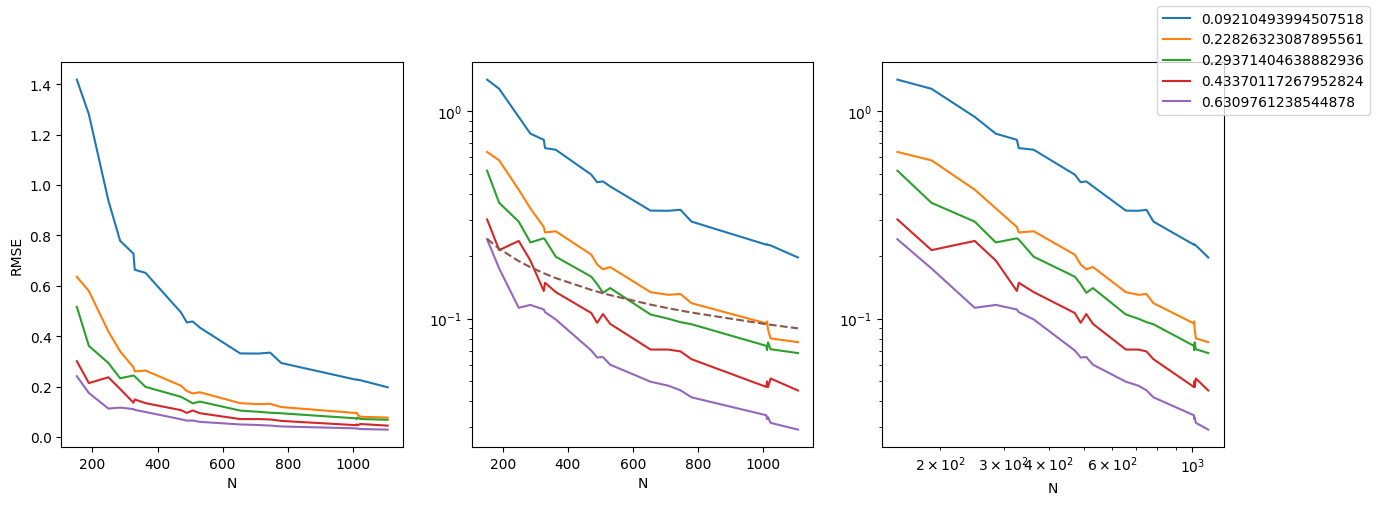

In [11]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5)) 

axs[0].set_ylabel("RMSE")
axs[1].set_yscale("log")
axs[2].set_xscale("log")
axs[2].set_yscale("log")

for epsilon_sim, subhistory in error_df.groupby("epsilon"):
    for ax in axs:
        subhistory.plot(x="N", y="error", label=epsilon_sim, ax=ax, legend=None)

# Get help from Net!
se = np.std(educ) / np.sqrt(n_sim)
axs[1].plot(n_sim, se, linestyle='dashed')
fig.legend(*axs[0].get_legend_handles_labels())



---



# *Question 3:* OPENDP

The OpenDP Project is a community effort to build trustworthy, open source software tools for analysis of private data. The core software of the OpenDP Project is the OpenDP Library.

The OpenDP Library is a modular collection of statistical algorithms that adhere to differential privacy. The library is based on a conceptual framework described in [A Programming Framework for OpenDP](https://projects.iq.harvard.edu/files/opendp/files/opendp_programming_framework_11may2020_1_01.pdf).

The OpenDP Library can be found on GitHub: https://github.com/opendp/opendp/

OpenDP represents computations with Transformations and Measurements. First, recall all you need from opendp, then create a measurement that simply addds laplace noise and like a function.

In [12]:
from opendp.meas import *
from opendp.trans import *
from opendp.typing import *
from opendp.mod import enable_features, Transformation, Measurement
enable_features("contrib", "floating-point")

base_laplace: Measurement = make_base_laplace(scale=0.5)

base_laplace(arg=23.)

n = educ.shape[0]
sized_bounded_mean: Transformation = make_sized_bounded_mean(size=n, bounds=(1., 16.))

sized_bounded_mean(arg=educ)

7042878440.0

We can also chain transformations and measurements. You might already think of chaining as function composition. The reason why we call it "chaining," instead of "composition," is because composition has a special meaning in differential privacy. In the context of differential privacy, composition refers to the joint release of more than one measurement.

In [13]:
# chain with the base_laplace measurement
dp_mean: Measurement = sized_bounded_mean >> base_laplace

# release a dp mean
dp_mean(arg=educ)

7042878439.376669

Now that we've shown how to build up computations and execute them, lets talk about distances.

Transformations and Measurements relate distances. There are three kinds of distances:

1. Dataset distances  
    (greatest distance between neighboring datasets)
1. Sensitivities  
    (greatest distance between queries on neighboring datasets)
1. Privacy budget    
    (greatest distance between the probability distributions)

The following shows how the `base_laplace` measurement relates a `sensitivity` to a privacy budget, `epsilon`.

In [14]:
# Check that when sensitivity is 0.15, the privacy usage is .30
base_laplace.check(d_in=.15, d_out=.30)

True

We can interpret this as: If the sensitivity is .15, then we could release the query answer with `laplace(scale=.5)` noise at a privacy expenditure of `.3 epsilon`. Equivalently, this data release is `.3 differentially private`, or `.3-DP`, where the privacy units are implicitly in terms of epsilon.

If we were to increase the sensitivity, the same relation would fail, and the release would not be `.3-DP`.

In [15]:
base_laplace.check(d_in=.17, d_out=.31)

False

As you might expect, the relation will also pass for any sensitivity that is smaller, or any privacy expenditure that is larger. And similarly, the `sized_bounded_mean` transformation relates a dataset distance `max_influence` to a `sensitivity`.

In [ ]:
sized_bounded_mean.check(d_in=1, d_out=.15)

True

Now relate distances on chained computations. The units for the input and output distances come from the constituent transformations and measurements.

For example, when we chain the `sized_bounded_mean` transformation and `base_laplace` measurement together, the input distance is a dataset distance, `max_influence`, and the output distance is measured in terms of a privacy budget, `epsilon`.

In [ ]:
dp_mean.check(d_in=1, d_out=.3)

True

The `release_histogram` function behaves similarly to the `make_count_by_categories` function in OpenDP.

In [ ]:
help(make_count_by_categories)

Help on function make_count_by_categories in module opendp.trans:

make_count_by_categories(categories: Any, MO: opendp.typing.SensitivityMetric = 'L1Distance<int>', TIA: Union[ForwardRef('RuntimeType'), _GenericAlias, str, Type[Union[List, Tuple, int, float, str, bool]], tuple] = None, TOA: Union[ForwardRef('RuntimeType'), _GenericAlias, str, Type[Union[List, Tuple, int, float, str, bool]], tuple] = 'int') -> opendp.mod.Transformation
    Make a Transformation that computes the number of times each category appears in the data. 
    This assumes that the category set is known.
    
    :param categories: The set of categories to compute counts for.
    :type categories: Any
    :param MO: output sensitivity metric
    :type MO: SensitivityMetric
    :param TIA: categorical/hashable input type. Input data must be Vec<TIA>.
    :type TIA: :ref:`RuntimeTypeDescriptor`
    :param TOA: express counts in terms of this numeric type
    :type TOA: :ref:`RuntimeTypeDescriptor`
    :return: A c

In [ ]:
# release a histogram with laplace noise


In [ ]:
# release a histogram with geometric noise




---



# *Question 4:* Gaussian Mechanism

Let's extend the basic building blocks to include a Gaussian mechanism and a random sampler from the Gaussian.

In [16]:
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt

In [17]:
#Gaussian
def Gaussian(shift, scale, size=None): 
    return np.random.normal(shift, scale, size)

#Clamp:
def Clamp(x, bounds):
    lower = bounds[0]
    upper = bounds[1]
    return np.clip(x, lower, upper)


#bounded mean:
def bounded_mean(x, bounds):
    return np.mean(Clamp(x, bounds))

#dp mean:
def release_dp_mean_gaussian(x, epsilon, bounds):
    delta = 1e-6
    n = len(x)
    sensitivity = (bounds[1]-bounds[0])/n
    scale = (sensitivity / epsilon) * np.sqrt(2*np.log(2/delta)) 
    return bounded_mean(x, bounds) + Gaussian(0, scale)

Read in the data. We are using the familiar PUMS dataset we are familiar with, and focusing on the education variable, a 16 point scale.

In [18]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")

n = len(data)
bounds = (1, 16)
educ = data['educ'].values.astype(float)
print("real mean: " , np.mean(educ))
print("DP mean: " , release_dp_mean_gaussian(educ, 1, bounds))    

real mean:  10.608553908251183
DP mean:  10.609553906850845


Now simulate repeated draws from both mechanisms to compare the utility they offer over a range of epsilon values and dataset sizes.  

In [19]:
def bootstrap(x, n):
  return np.random.choice(x, n)

n_sim = np.random.randint(150, 1150, 20)
eps_sim = np.random.rand(5)

n_sim = sorted(n_sim)
eps_sim = sorted(eps_sim) 

errors = []

for n_i in n_sim:
  for eps_i in eps_sim:
    tot_err = 0
    for k in range(n_i):
      sim_data = bootstrap(educ, n_i)
      real_mean = np.mean(sim_data)
      dp_mean = release_dp_mean_gaussian(sim_data, eps_i, [1,16])
      tot_err += (real_mean - dp_mean)**2

    errors.append([n_i, eps_i, np.sqrt(tot_err/n_i)])



error_df = pd.DataFrame(errors, columns=["N", "epsilon", "error"])

print(error_df)


       N   epsilon     error
0    180  0.258988  1.698024
1    180  0.391455  1.065976
2    180  0.423962  1.063739
3    180  0.468675  0.908442
4    180  0.603735  0.720580
..   ...       ...       ...
95  1136  0.258988  0.285299
96  1136  0.391455  0.186028
97  1136  0.423962  0.165448
98  1136  0.468675  0.154810
99  1136  0.603735  0.117300

[100 rows x 3 columns]


And Finally Graph your result:

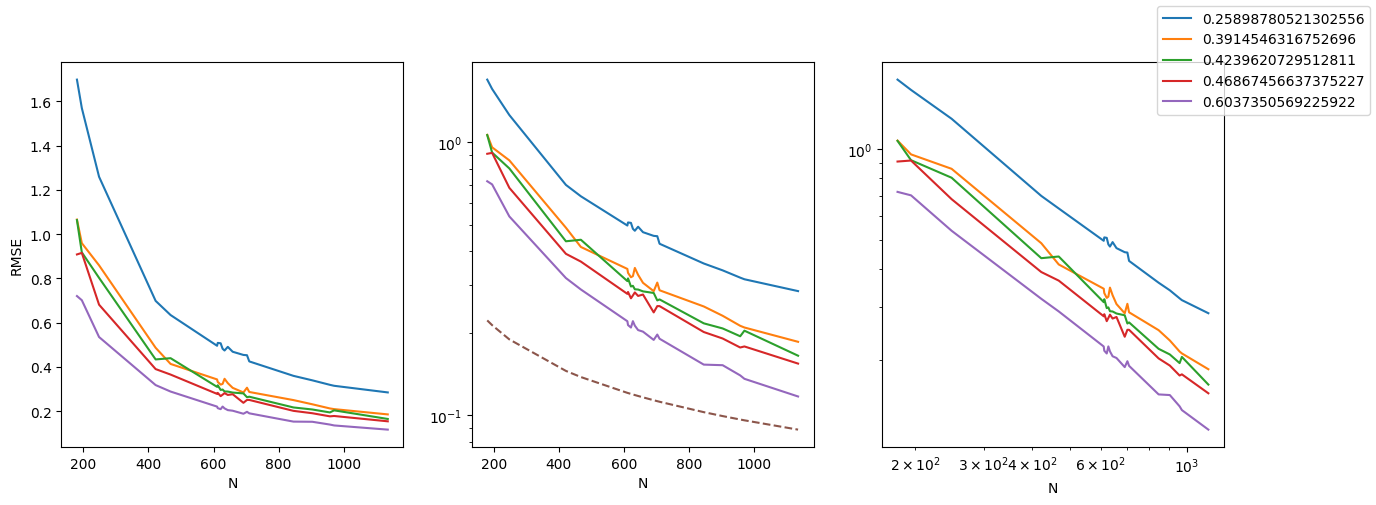

In [20]:
fig, axs = plt.subplots(ncols=3, figsize=(15,5)) 

axs[0].set_ylabel("RMSE")
axs[1].set_yscale("log")
axs[2].set_xscale("log")
axs[2].set_yscale("log")

for epsilon_sim, subhistory in error_df.groupby("epsilon"):
    for ax in axs:
        subhistory.plot(x="N", y="error", label=epsilon_sim, ax=ax, legend=None)

se = np.std(educ) / np.sqrt(n_sim)
axs[1].plot(n_sim, se, linestyle='dashed')
fig.legend(*axs[0].get_legend_handles_labels())